# Predicting tips

In this notebook, we consider the following:

> Can we predict how much tip a driver will get based on the conditions of a trip?

## Classification problem: will the trip get tipped?

We wish to predict whether or not a trip gets tipped, using classification models. We take a measured approach, first considering logistic regression with univariate analysis, and then combining strong predictors using `xgboost`.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import numpy as np
import seaborn as sns
from scipy import stats

In [2]:
date_ptr = '2009-01'
data_arr = []

while date_ptr != '2024-01':
    date_data = pd.read_parquet(f'../data/tr_data/{date_ptr}.parquet')
    data_arr.append(date_data)
    date_ptr = (pd.to_datetime(date_ptr) + pd.DateOffset(months=1)).strftime('%Y-%m')

data_df = pd.concat(data_arr)

### Univariate analysis

One thing to note is that we won't know how long the trip will be before the trip ends, so we can't use this as this has lookahead bias.

#### Trip distance

Text(0.5, 0, 'Trip distance (miles)')

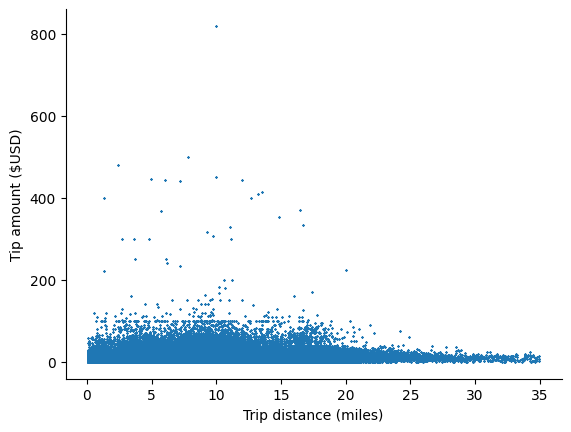

In [23]:
plt.scatter(data_df['trip_distance'], data_df['tip_amount'], marker='x', s=1)
sns.despine()
plt.ylabel('Tip amount ($USD)')
plt.xlabel('Trip distance (miles)')

Text(0.5, 0, 'Trip distance(miles)')

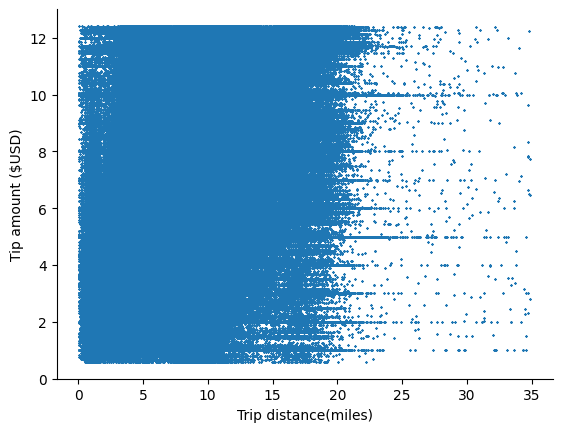

In [ ]:
data_df['tip_amount_zscore'] = stats.zscore(data_df['tip_amount'])
no_outliers = data_df[abs(data_df['tip_amount_zscore']) < 2].copy()

plt.scatter(no_outliers['trip_distance'], no_outliers['tip_amount'], marker='x', s=1)
sns.despine()
plt.ylabel('Tip amount ($USD)')
plt.xlabel('Trip distance(miles)')

The above is obviously quite hard to see, as there is so many data points, so we'll bucket and see if there exists any relationship at the mean level.

Text(0, 0.5, 'Mean tip amount ($USD)')

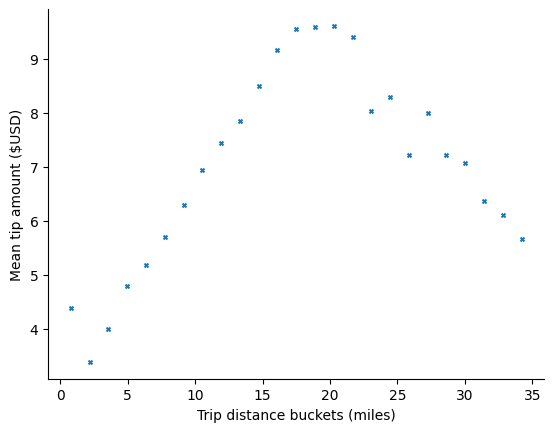

In [42]:
no_outliers['trip_distance_bucket'] = pd.cut(no_outliers['trip_distance'], 25).apply(lambda x: (x.left + x.right) / 2)
no_outliers_mean = no_outliers.groupby('trip_distance_bucket', observed=False)['tip_amount'].mean()

plt.scatter(no_outliers_mean.index, no_outliers_mean, marker='x', s=8)
sns.despine()
plt.xlabel('Trip distance buckets (miles)')
plt.ylabel('Mean tip amount ($USD)')

There exists a strong linear relationship from `0 -> 20` miles, but then this reverts down. We use `xgboost` to fit a tree on the whole data set.

In [53]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

X = no_outliers[['trip_distance']]
y = no_outliers['tip_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

We test different learning rates, using mean absolute error.

In [61]:
for lr in [0.001, 0.01, 0.1, 0.3, 0.5]:
    model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=4,
    learning_rate=lr,
    objective='reg:squarederror',
    random_state=42
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Learning rate: {lr}\t|\tMAE: {mae}')

Learning rate: 0.001	|	MAE: 1.7606927781907733
Learning rate: 0.01	|	MAE: 1.5837253754899472
Learning rate: 0.1	|	MAE: 1.5197685502154896
Learning rate: 0.3	|	MAE: 1.5197513190293719
Learning rate: 0.5	|	MAE: 1.51978275932583


We use a learning rate of 0.1.

In [64]:
final_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    objective='reg:squarederror',
    random_state=42
)
final_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

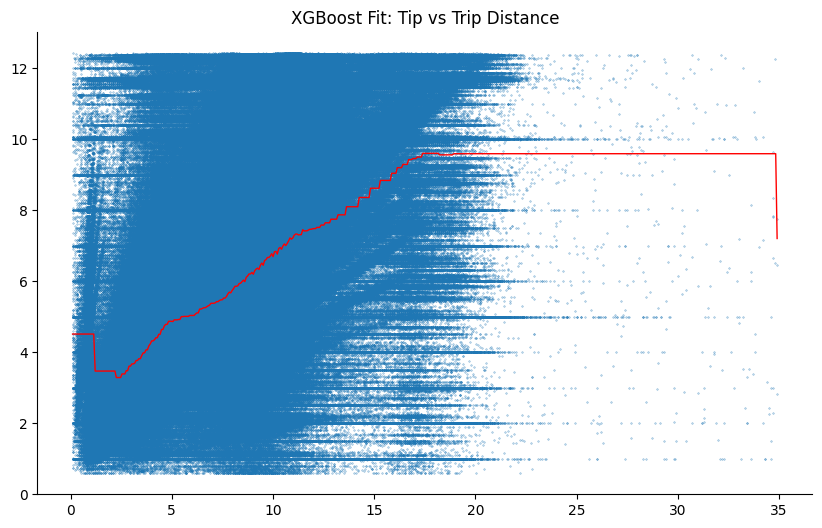

In [66]:
x_line = np.linspace(X['trip_distance'].min(), X['trip_distance'].max(), 500).reshape(-1, 1)
y_pred_line = final_model.predict(x_line)

plt.figure(figsize=(10, 6))
plt.scatter(X['trip_distance'], y, marker='x', s=1, alpha=0.3)
plt.plot(x_line, y_pred_line, color='red', linewidth=1)
sns.despine()
plt.title('XGBoost Fit: Tip vs Trip Distance')
plt.show()

`xgboost` is able to capture how many people simply pay 5 dollars. Let's talk about some features of the model:
- The first few miles have an interesting property, where people pay a flat ~5 dollar tip. You can actually see how shorter trips exhibit different behaviour, with the small cone that can be seen on the left
- Otherwise, we see on the bucketed scatter plot that there is a fairly strong positive linear relationship from `0 -> 20` miles.
- Mean absolute error of $1.5

### Clustering on trip pickup

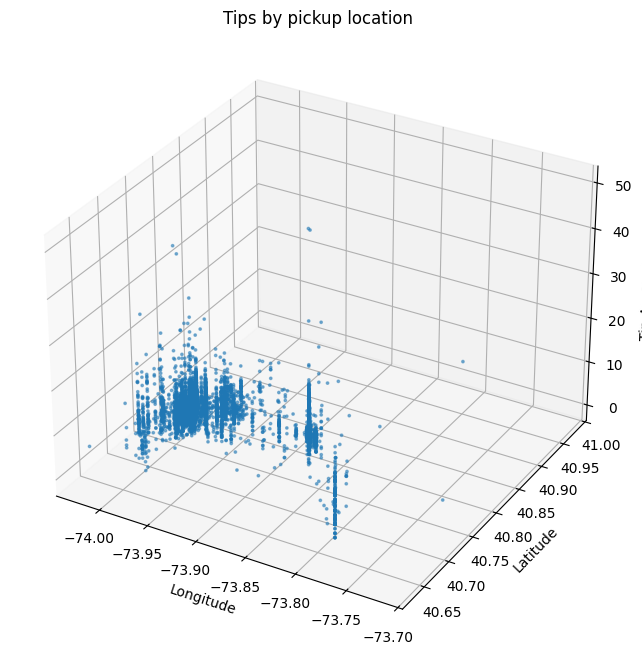

In [15]:
sample_df = data_df.sample(n=10000, random_state=42)
sample_df = sample_df[
    (sample_df['pickup_longitude'] < -73.5)
]

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(sample_df['pickup_longitude'], sample_df['pickup_latitude'], sample_df['tip_amount'], s=3, alpha=0.5)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Tip Amount ($)')
plt.title('Tips by pickup location')
plt.show()

There doesn't appear to be any specific pickup location specific clustering - particularly since New York City is so dense

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,payment_type,fare_amount,tip_amount,trip_time_in_secs,fare_per_sec,day,time,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
116,2009-01-07 13:12:59,2009-01-07 13:30:39,1.0,9.70,Credit,22.5,5.33,1060.0,0.021226,Wednesday,13:12:59,-73.983312,40.738635,-73.861561,40.768269
446,2009-01-13 05:28:00,2009-01-13 05:45:00,1.0,11.49,Credit,26.1,5.32,1020.0,0.025588,Tuesday,05:28:00,-73.978822,40.763988,-73.864905,40.770447
524,2009-01-14 10:42:00,2009-01-14 10:59:00,1.0,8.13,Credit,19.7,5.00,1020.0,0.019314,Wednesday,10:42:00,-73.874530,40.774177,-73.876870,40.773007
865,2009-01-15 06:38:00,2009-01-15 06:57:00,5.0,8.31,Credit,20.9,4.18,1140.0,0.018333,Thursday,06:38:00,-73.956920,40.766343,-73.885357,40.770815
924,2009-01-08 06:29:00,2009-01-08 06:49:00,1.0,10.33,Credit,24.1,6.00,1200.0,0.020083,Thursday,06:29:00,-73.989220,40.758418,-73.862137,40.768610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3196388,2023-12-31 23:04:21,2023-12-31 23:30:39,1.0,18.58,1,70.0,20.23,1578.0,0.044360,Sunday,23:04:21,-73.779373,40.642948,-73.961292,40.776654
3196469,2023-12-31 23:52:48,2024-01-01 00:07:43,1.0,9.16,1,35.2,7.00,895.0,0.039330,Sunday,23:52:48,-73.873364,40.775714,-73.959017,40.766437
3196482,2023-12-31 22:59:58,2023-12-31 23:30:41,1.0,17.87,1,70.0,8.27,1843.0,0.037982,Sunday,22:59:58,-73.779373,40.642948,-73.987361,40.729269
3196511,2023-12-31 23:39:17,2023-12-31 23:56:27,2.0,5.89,1,26.8,7.75,1030.0,0.026019,Sunday,23:39:17,-73.972471,40.759822,-73.930469,40.721055
